In [25]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 1. 加载和预处理数据
data_dir = '../data/raw'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 480 images belonging to 15 classes.


Found 120 images belonging to 15 classes.


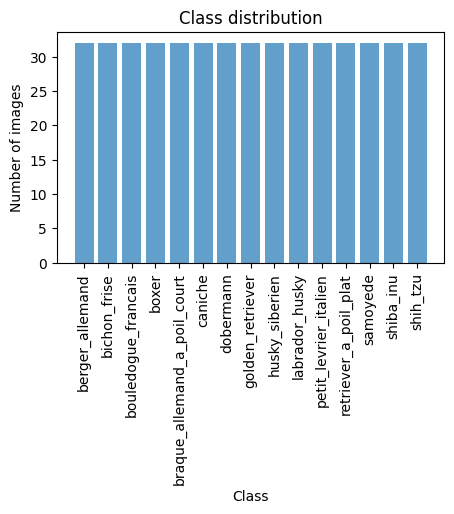

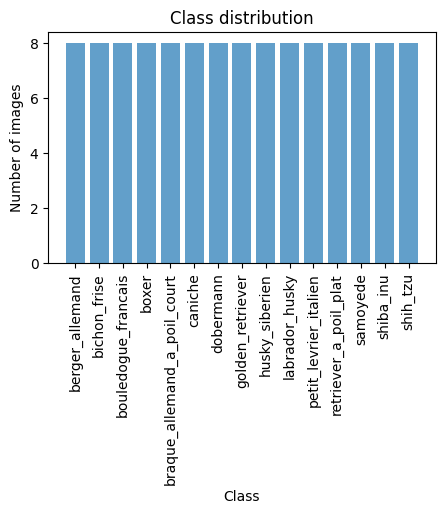

In [26]:
def plot_class_distribution(generator):
    class_counts = np.bincount(generator.classes)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(5, 3))
    plt.bar(class_labels, class_counts, alpha=0.7)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Class distribution')
    plt.xticks(rotation=90)
    plt.show()

# 可视化训练集类别分布
plot_class_distribution(train_generator)

# 可视化验证集类别分布
plot_class_distribution(validation_generator)


In [27]:
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense

# 构建模型
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 冻结预训练模型的层
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 添加早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 训练模型
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, callbacks=[early_stopping])

Epoch 1/15


/Users/xinleichen/miniconda3/envs/myenv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.0869 - loss: 5.5715 - val_accuracy: 0.1167 - val_loss: 2.7976
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3268 - loss: 2.1922 - val_accuracy: 0.2000 - val_loss: 2.5586
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.5430 - loss: 1.6606 - val_accuracy: 0.2417 - val_loss: 2.2736
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8067 - loss: 0.9865 - val_accuracy: 0.3500 - val_loss: 2.1181
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9314 - loss: 0.5993 - val_accuracy: 0.3250 - val_loss: 2.0174
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9661 - loss: 0.4260 - val_accuracy: 0.4167 - val_loss: 1.9277
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9942 - loss: 0.2685 - val_accuracy: 0.3750 - val_loss: 1.8991
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 1.0000 - loss: 0.1874 - val_accuracy: 0.3750 - val_loss: 1.9322
Epo

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step
Classification Report:
                               precision    recall  f1-score   support

             berger_allemand       0.00      0.00      0.00         8
                bichon_frise       0.25      0.38      0.30         8
         bouledogue_francais       0.00      0.00      0.00         8
                       boxer       0.14      0.12      0.13         8
braque_allemand_a_poil_court       0.00      0.00      0.00         8
                     caniche       0.09      0.12      0.11         8
                   dobermann       0.12      0.12      0.12         8
            golden_retriever       0.00      0.00      0.00         8
              husky_siberien       0.10      0.12      0.11         8
              labrador_husky       0.25      0.12      0.17         8
       petit_levrier_italien       0.00      0.00      0.00         8
       retriever_a_poil_plat       0.00      0.00      0.00         8
                    samoyede 

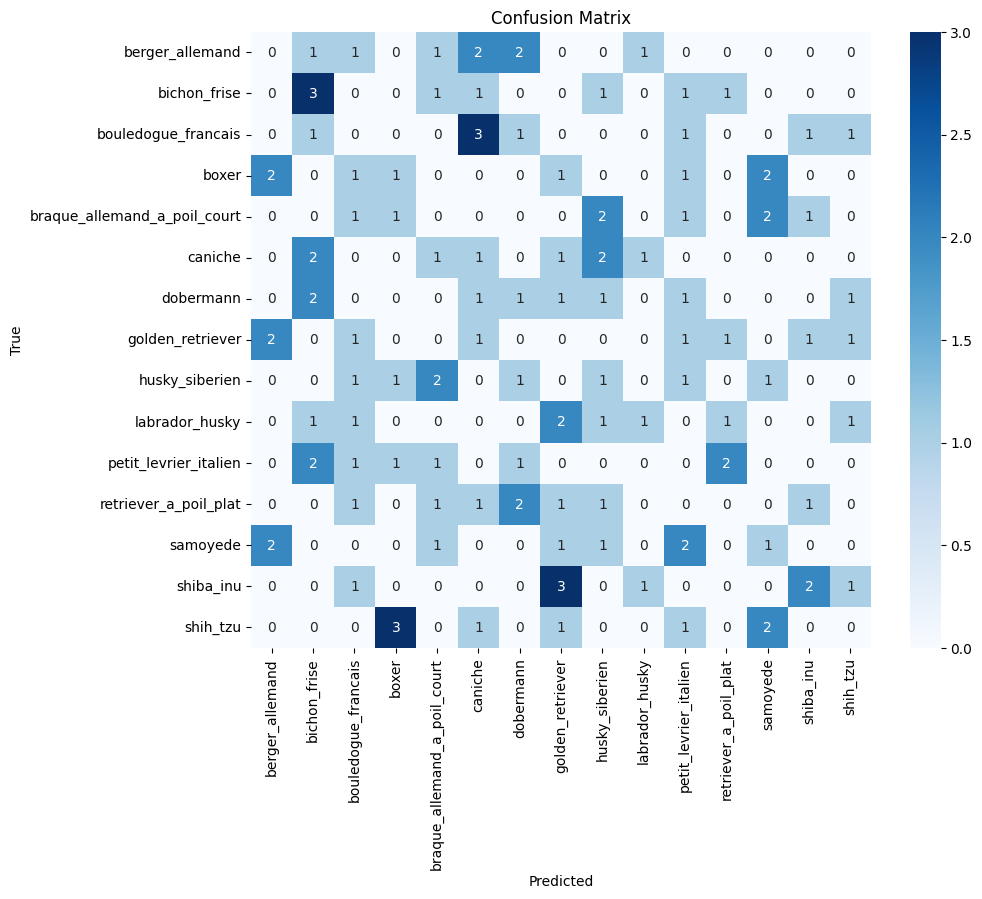

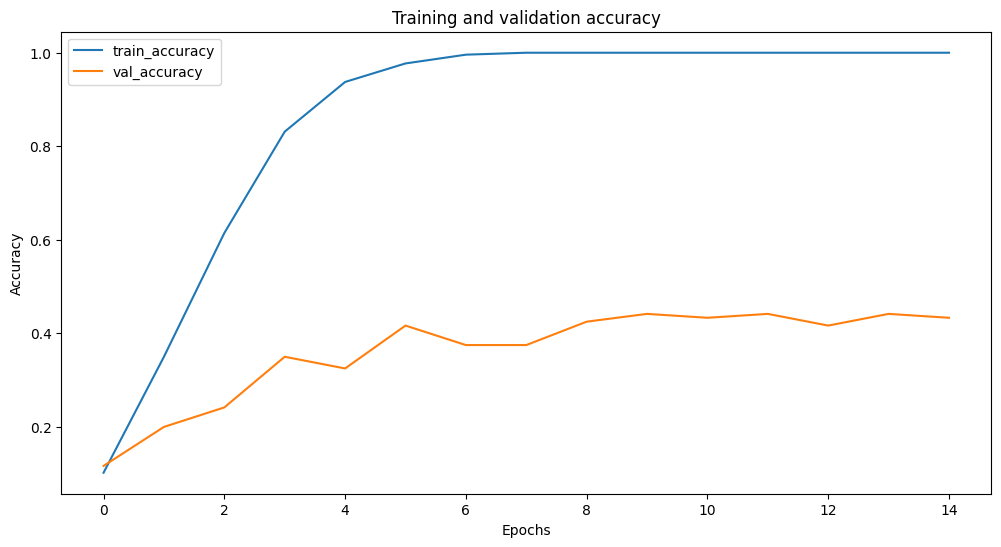

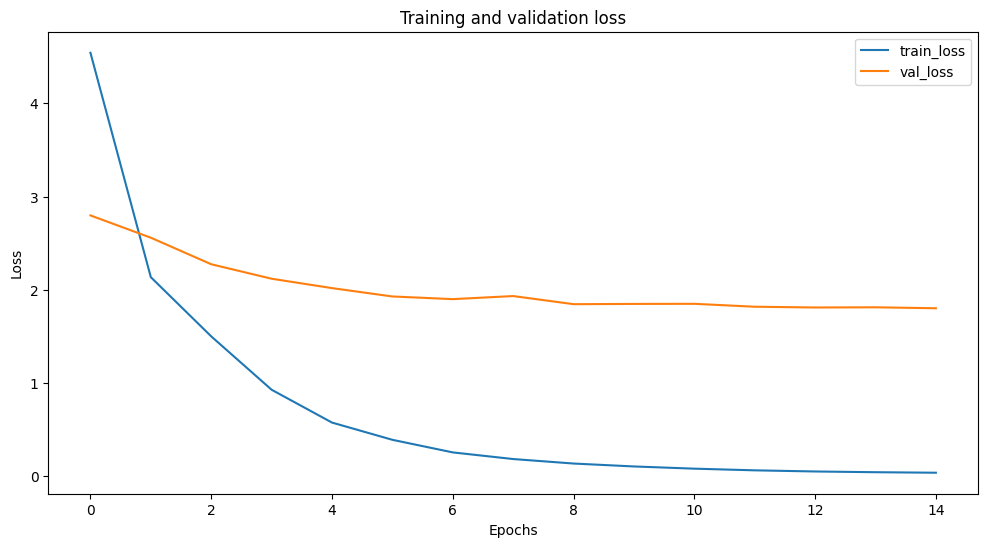

In [31]:
# 评估模型
validation_generator.reset()
predictions = model.predict(validation_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes

# 计算分类报告和混淆矩阵
report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
matrix = confusion_matrix(y_true, y_pred)

# 输出分类报告和混淆矩阵
print("Classification Report:\n", report)
print("Confusion Matrix:\n", matrix)

# 保存结果到文件
with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump({'report': report, 'matrix': matrix}, f)

# 读取结果并输出
with open('evaluation_results.pkl', 'rb') as f:
    results = pickle.load(f)
    print("Saved Classification Report:\n", results['report'])
    print("Saved Confusion Matrix:\n", results['matrix'])

# 绘制混淆矩阵
def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_labels = list(validation_generator.class_indices.keys())
plot_confusion_matrix(matrix, class_labels)

# 可视化训练过程
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_history(history)